# Titanic Survival Prediction

## Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

## Exploration

In [17]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [18]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [19]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Feature Engineering

In [20]:
combined = pd.concat([train_df, test_df], sort=False)

In [21]:
combined['FamilySize'] = combined['SibSp'] + combined['Parch'] + 1
combined['IsAlone'] = (combined['FamilySize'] == 1).astype(int)

combined['Sex'] = combined['Sex'].map({'male': 0, 'female': 1})
combined['Embarked'] = combined['Embarked'].fillna('S').map({'S': 0, 'C': 1, 'Q': 2})
combined['Age'] = combined['Age'].fillna(combined['Age'].median())
combined['Fare'] = combined['Fare'].fillna(combined['Fare'].median())

combined['Title'] = combined['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
combined['Title'] = combined['Title'].replace(['Lady', 'Countess','Capt','Col','Don','Dr','Major',
                                               'Rev','Sir','Jonkheer','Dona'], 'Rare')
combined['Title'] = combined['Title'].map({"Mr":1, "Miss":2, "Mrs":3, "Master":4, "Rare":5})
combined['Title'] = combined['Title'].fillna(0)

combined.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

train_df = combined[:len(train_df)]
test_df = combined[len(train_df):]

X = train_df.drop(['Survived', 'PassengerId'], axis=1)
y = train_df['Survived']
X_test_final = test_df.drop(['Survived', 'PassengerId'], axis=1)

## Train Test Split

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Grid Search

In [23]:
param_grid_all = {
    'RandomForestClassifier': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5]
    },
    'SVC': {
        'C': [1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale']
    },
    'LogisticRegression': {
        'C': [0.1, 1],
        'penalty': ['l2'],
        'solver': ['liblinear']
    }
}

models = {
    'RandomForestClassifier': RandomForestClassifier(),
    'SVC': SVC(probability=True),
    'LogisticRegression': LogisticRegression()
}

best_models = {}
for name, model in models.items():
    grid = GridSearchCV(model, param_grid_all[name], cv=5, scoring='accuracy')
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"Best parameters for {name}: {grid.best_params_}")
    

Best parameters for RandomForestClassifier: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters for SVC: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best parameters for LogisticRegression: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [24]:
for name, model in best_models.items():
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"{name} accuracy: {acc:.4f}")

RandomForestClassifier accuracy: 0.8547
SVC accuracy: 0.7877
LogisticRegression accuracy: 0.7877


In [26]:
best_model = best_models['RandomForestClassifier']
y_pred_val = best_model.predict(X_val)

print(confusion_matrix(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

[[95 10]
 [16 58]]
              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88       105
         1.0       0.85      0.78      0.82        74

    accuracy                           0.85       179
   macro avg       0.85      0.84      0.85       179
weighted avg       0.85      0.85      0.85       179



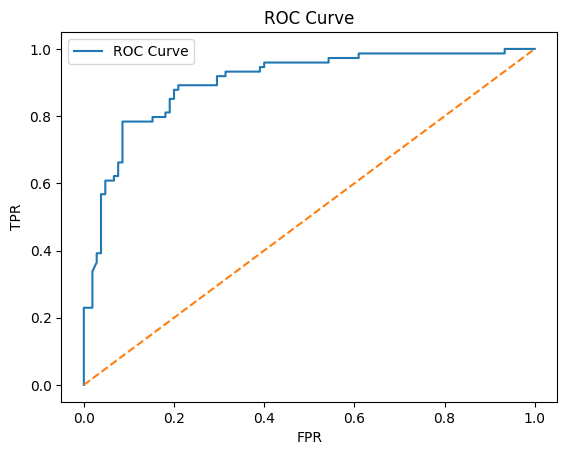

ROC-AUC: 0.9019


In [27]:
y_probs = best_model.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_probs)

plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

print(f"ROC-AUC: {roc_auc_score(y_val, y_probs):.4f}")

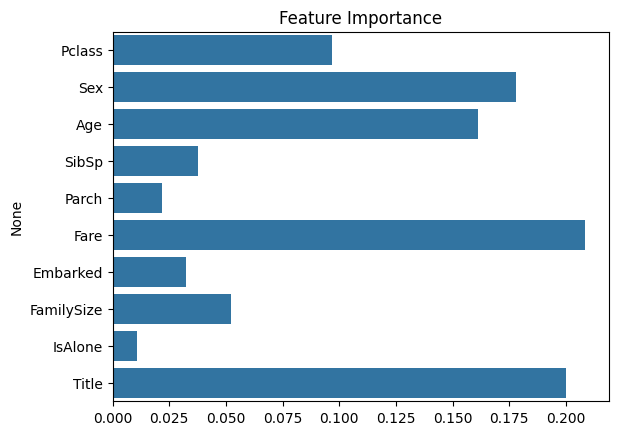

In [28]:
importances = best_model.feature_importances_
features = X.columns

sns.barplot(x=importances, y=features)
plt.title("Feature Importance")
plt.show()

In [33]:
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': y_pred_final.astype(int)
})
submission.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")
print(submission['Survived'].value_counts())

Submission file created: submission.csv
Survived
0    275
1    143
Name: count, dtype: int64
